In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [5]:
def load_proton_a_images(n=None):
    data = pd.read_pickle('../data/proton_images2a.pkl')
    return data[:n]

def load_neutron_a_images(n=None):
    data = pd.read_pickle('../data/neutron_images2a.pkl')
    return data[:n]

def load_particle_data_a(n=None):
    data = pd.read_pickle('../data/particles_cond_with_mass2a.pkl')
    return data[:n]

In [6]:
N_SAMPLES = None
data_p = load_proton_a_images(N_SAMPLES)
print('Loaded Proton: ',  data_p.shape)

data_n = load_neutron_a_images(N_SAMPLES)
print('Loaded Neutron: ',  data_n.shape)

data_cond = load_particle_data_a(N_SAMPLES)
print('Loaded cond: ',  data_cond.shape)

Loaded Proton:  (175636, 56, 30)
Loaded Neutron:  (175636, 44, 44)
Loaded cond:  (175636, 11)


Suma fotonów:  5.0


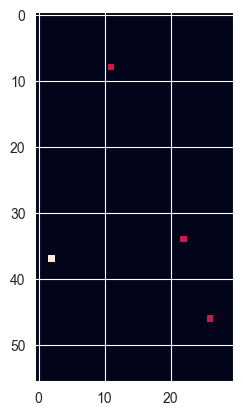

In [7]:
print("Suma fotonów: ", data_p[3].sum())
plt.imshow(data_p[3])

In [92]:
data_cond.iloc[3]

Pdg         -211.000000
Energy       325.158000
Vx             0.000000
Vy             0.000000
Vz             0.000000
Px             0.269915
Py            -0.081921
Pz           325.157000
PhotonSum      0.000000
mass         139.570610
charge        -1.000000
Name: 3, dtype: float64

## Filter Photon Sum

In [93]:
def filter_photon_sum(data_response, data_conditional, min_photon_sum=10):
    """
    Returns particle data and responses of experiments with minimum sum of photons.
    """
    indecies = data_conditional.index[data_conditional.loc[:, 'PhotonSum'] >= min_photon_sum]
    return data_response[indecies], data_conditional.iloc[indecies].reset_index(drop=True)

In [94]:
MIN_PHOTON_SUM = 30

data, data_cond = filter_photon_sum(data, data_cond, min_photon_sum=MIN_PHOTON_SUM)
data.shape, data_cond.shape

((89125, 56, 30), (89125, 11))

## Add padding

Two sizes of images:
- 56 x 30
- 44 x 44

__Goal:__ Add padding to images to transform them to common size: 56 x 44

__Approaches:__
- add padding around the images (center the content)
- add padding to one side of images

In [9]:
from enum import Enum

class PaddingMethod(Enum):
    CENTER = 0
    LEFT_SIDE = 0

In [23]:
def add_padding_56_30(image, method: PaddingMethod = PaddingMethod.CENTER.name):
    """
    Transform image of shape(56, 30) into shape(56, 44).
    :param method: Method of adding padding
    :param image: Image of shape(56, 30)
    :returns: Image of shape(56, 44)
    """
    if method == PaddingMethod.CENTER.name:
        # Add 7 pixels to the left and right side of image
        return np.pad(image,
                      pad_width=((0, 0), (7, 7)),
                      mode='constant', constant_values=0)


def add_padding_44_44(image, method: PaddingMethod = PaddingMethod.CENTER.name):
    """
    Transform image of shape(44, 44) into shape(56, 44).
    :param method: Method of adding padding
    :param image: Image of shape(44, 44)
    :returns: Image of shape(56, 44)
    """
    if method == PaddingMethod.CENTER.name:
        # Add 7 pixels to the top and bottom side of image
        return np.pad(image,
                      pad_width=((6, 6), (0, 0)),
                      mode='constant', constant_values=0)

In [19]:
padded_p = np.array(list(map(add_padding_56_30, data_p)))

In [24]:
padded_n = np.array(list(map(add_padding_44_44, data_n)))

In [25]:
padded_p.shape, padded_n.shape

((175636, 56, 44), (175636, 56, 44))

## Combine images into two channels

Given the padded images, combine them into a single image with 2 channels

In [26]:
def combine_into_channels(data_1, data_2):
    return np.dstack((data_1, data_2))

In [27]:
data = combine_into_channels(padded_p, padded_n)

In [28]:
data.shape

(175636, 56, 88)

(<matplotlib.image.AxesImage at 0x234a3cc7c70>, 1256.0)

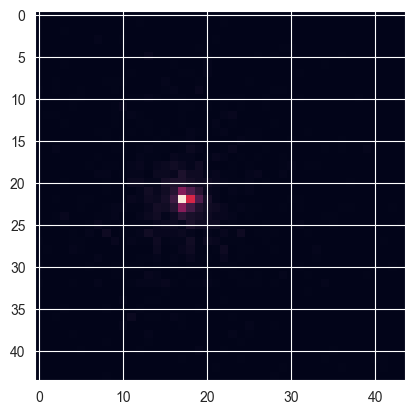

In [78]:
plt.imshow(data[2], interpolation='none'), data[2].sum()

## Save files

In [34]:
data_cond.to_pickle(f"../data/data_cond_photonsum_{MIN_PHOTON_SUM}.pkl")

In [35]:
with open(f"../data/data_photonsum_{MIN_PHOTON_SUM}.pkl", 'wb') as f:
    pickle.dump(data, f)